In [1]:
%load_ext watermark
# sys, file and nav packages:
import datetime as dt
import json
import functools
import time
from os import listdir
from os.path import isfile, join

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import seaborn as sns

import IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display
from myst_nb import glue

import time

unit_label = 'p/100m'

# survey data:
dfx= pd.read_csv('resources/checked_sdata_eos_2020_21.csv')


dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

# set the index of to codes
dfCodes.set_index("code", inplace=True)

# code description map
code_d_map = dfCodes.description.copy()

# shorten the descriptions of two codes
code_d_map.loc["G38"] = "sheeting for protecting large cargo items"
code_d_map.loc["G73"] = "Foamed items & pieces (non packaging/insulation)"

# code material map
code_m_map = dfCodes.material

# this defines the css rules for the note-book table displays
header_row = {'selector': 'th:nth-child(1)', 'props': f'background-color: #FFF;'}
even_rows = {"selector": 'tr:nth-child(even)', 'props': f'background-color: rgba(139, 69, 19, 0.08);'}
odd_rows = {'selector': 'tr:nth-child(odd)', 'props': 'background: #FFF;'}
table_font = {'selector': 'tr', 'props': 'font-size: 12px;'}
table_css_styles = [even_rows, odd_rows, table_font, header_row]

pdtype = pd.core.frame.DataFrame
pstype = pd.core.series.Series

def scaleTheColumn(x):
    
    xmin = x.min()
    xmax = x.max()
    xscaled = (x-xmin)/(xmax-xmin)
    
    return xscaled

def collectAggregateValues(data: pd.DataFrame = None, locations: [] = None, columns: list = ["location", "OBJVAL"], to_aggregate: str = None):
    return data[data.location.isin(locations)].groupby(columns, as_index=False)[to_aggregate].sum()

def pivotValues(aggregate_values, index: str = "location", columns: str = "OBJVAL", values: str = "surface"):
    return aggregate_values.pivot(index=index, columns=columns, values=values).fillna(0)
    
def collectAndPivot(data: pd.DataFrame = None, locations: [] = None, columns: list = ["location", "OBJVAL"], to_aggregate: str = None):
    # collects the geo data and aggregates the categories for a 3000 m hex
    # the total for each category is the total amount for that category in the specific 3000 m hex
    # with the center defined by the survey location.
    aggregated = collectAggregateValues(data=data, locations=locations, columns=columns, to_aggregate=to_aggregate)
    pivoted = pivotValues(aggregated, index=columns[0], columns=columns[1], values=to_aggregate)
    pivoted.columns.name = "None"
    return pivoted.reset_index(drop=False)

def resultsDf(rhovals: pdtype = None, pvals: pdtype = None)-> pdtype:
    # masks the values of rho where p > .05
    results_df = []
    for i, n in enumerate(pvals.index):
        arow_of_ps = pvals.iloc[i]
        p_fail = arow_of_ps[ arow_of_ps > 0.05]
        
        arow_of_rhos = rhovals.iloc[i]
        
        for label in p_fail.index:
            if arow_of_rhos[label] == 1:
                pass
            else:
                arow_of_rhos[label] = 0
        results_df.append(arow_of_rhos)
    
    return results_df

def rotateText(x):
    return 'writing-mode: vertical-lr; transform: rotate(-180deg);  padding:10px; margins:0; vertical-align: baseline;'

def aStyledCorrelationTable(data, columns = ['Obstanlage', 'Reben', 'Siedl', 'Stadtzentr', 'Wald', 'k/n']):
    rho = data[columns].corr(method='spearman')
    pval = data[columns].corr(method=lambda x, y: stats.spearmanr(x, y)[1])
    pless = pd.DataFrame(resultsDf(rho, pval))

    pless.columns.name = None
    bfr = pless.style.format(precision=2).set_table_styles(table_css_styles)
    bfr = bfr.background_gradient(axis=None, vmin=rho.min().min(), vmax=rho.max().max(), cmap="coolwarm")
    bfr = bfr.applymap_index(rotateText, axis=1)
    return bfr

def addExceededTested(data, exceeded, passed, ratio, tested):
    # merges the results of test threshold on to the survey results
    data = data.merge(exceeded, left_on='location', right_index=True)
    data = data.merge(passed, left_on='location', right_index=True)
    data = data.merge(ratio, left_on="location", right_index=True)
    data = data.merge(tested, left_on="location", right_index=True)
    
    return data

def testThreshold(data, threshold, gby_column):
    # given a data frame, a threshold and a groupby column
    # the given threshold will be tested against the sum
    # of aggregated value produced by aggregating on the
    # groupby column
    
    res_code["k"] = data.pcs_m >= threshold
    exceeded = data.groupby([gby_column])['k'].sum()
    exceeded.name = "k"
    
    tested = data.groupby([gby_column]).loc_date.nunique()
    tested.name = 'n'
    
    passed = tested-exceeded
    passed.name = "n-k"
    
    ratio = exceeded/tested
    ratio.name = 'k/n'
    
    return exceeded, tested, passed, ratio

class CodeResults:   
        
    def __init__(self, data, attributes, column="pcs_m", method = stats.spearmanr):        
        
        self.code_data = data
        self.attributes = attributes
        self.column = column
        self.x = self.code_data[column]
        self.method = method
       
        self.y = None
        
        super().__init__()
    
        
    def getRho(self, x: np.array = None)-> float:
        # assigns y from self        
        result = self.method(x, self.y)
                               
        return result.correlation            
        
    def exactPValueForRho(self)-> float:
        # perform a permutation test instead of relying on 
        # the asymptotic p-value. Only one of the two inputs 
        # needs to be shuffled.
        p = stats.permutation_test((self.x,) , self.getRho, permutation_type='pairings', n_resamples=1000)
        
        
        return p.pvalue
    def rhoForAGroupOfAttributes(self):
        # returns the results of the
        # the correlation test, including 
        # a permutation test on p
        rhos = []
        code = self.code_data.code.unique()[0]
        for attribute in self.attributes:
            self.y = self.code_data[attribute].values
            c= self.getRho(self.x)
            p = self.exactPValueForRho()
            
        # rhos.append({"code":code, "attribute":attribute, "c":c, "p":p.statistic})
        return {"code":code, "attribute":attribute, "c":c, "p":p}


def rhoForAGroupOfAttributes(data, attributes, column="pcs_m"):
    rhos = []
    code = data.code.unique()[0]
    for attribute in attributes:
        p = CodeResults(data, [attribute],column=column).rhoForAGroupOfAttributes()
        rhos.append(p)
    return rhos

def cleanSurveyResults(data):
    # performs data cleaning operations on the
    # default data ! this does not remove 
    # Walensee ! The new map data is complete    
    data['loc_date'] = list(zip(data.location, data["date"]))
    data['date'] = pd.to_datetime(data["date"])
    
    # get rid of microplastics
    mcr = data[data.groupname == "micro plastics (< 5mm)"].code.unique()
    
    # replace the bad code
    data.code = data.code.replace('G207', 'G208')
    data = data[~data.code.isin(mcr)]
    
    # walensee has no landuse values
    # data = data[data.water_name_slug != 'walensee']   
    
    return data

class SurveyResults:
    """Creates a dataframe from a valid filename. Assigns the column names and defines a list of
    codes and locations that can be used in the CodeData class.
    """
    
    file_name = 'resources/checked_sdata_eos_2020_21.csv'
    columns_to_keep=[
        'loc_date',
        'location', 
        'river_bassin',
        'water_name_slug',
        'city',
        'w_t', 
        'intersects', 
        'code', 
        'pcs_m',
        'quantity'
    ]
        
    def __init__(self, data: str = file_name, clean_data: bool = True, columns: list = columns_to_keep, w_t: str = None):
        self.dfx = pd.read_csv(data)
        self.df_results = None
        self.locations = None
        self.valid_codes = None
        self.clean_data = clean_data
        self.columns = columns
        self.w_t = w_t
        
    def validCodes(self):
        # creates a list of unique code values for the data set    
        conditions = [
            isinstance(self.df_results, pdtype),
            "code" in self.df_results.columns
        ]

        if all(conditions):

            try:
                valid_codes = self.df_results.code.unique()
            except ValueError:
                print("There was an error retrieving the unique code names, self.df.code.unique() failed.")
                raise
            else:
                self.valid_codes = valid_codes
                
        
    def surveyResults(self):
        
        # if this method has been called already
        # return the result
        if self.df_results is not None:
            return self.df_results
        
        # for the default data self.clean data must be called        
        if self.clean_data is True:
            fd = cleanSurveyResults(self.dfx)
            
        # if the data is clean then if can be used directly
        else:
            fd = self.dfx
        
        # filter the data by the variable w_t
        if self.w_t is not None:
            fd = fd[fd.w_t == self.w_t]            
         
        # keep only the required columns
        if self.columns:
            fd = fd[self.columns]
        
        # assign the survey results to the class attribute
        self.df_results = fd
        
        # define the list of codes in this df
        self.validCodes()
        
        return self.df_results
    
    def surveyLocations(self):
        if self.locations is not None:
            return self.locations
        if self.df_results is not None:
            self.locations = self.dfResults.location.unique()
            return self.locations
        else:
            print("There is no survey data loaded")
            return None    

# def resultsDf(rhovals: pdtype = None, pvals: pdtype = None)-> pdtype:
#     results_df = []
#     for i, n in enumerate(pvals.index):
#         arow_of_ps = pvals.iloc[i]
#         p_fail = arow_of_ps[ arow_of_ps > 0.05]
#         arow_of_rhos = rhovals.iloc[i]
        
#         for label in p_fail.index:
#             arow_of_rhos[label] = 0
#         results_df.append(arow_of_rhos)
    
#     return results_df

# def rotateText(x):
#     return 'writing-mode: vertical-lr; transform: rotate(-180deg);  padding:10px; margins:0; vertical-align: baseline;'

# All Data -- New map data

This document repeats the calculations in the first three sections and incorporates the methods in the fourth section. There are some key differnces:

1. There are no excluded regions
2. There is geo-data for all regions under consieration

## Important changes

The land-use categories are labeled differently. The new map data from [swissTLM3d](https://www.swisstopo.admin.ch/fr/geodata/landscape/tlm3d.html#dokumente) does not have the general class agriculture. Any un-labeled surface in the hex was accounted for by subsracting the total of all labeled categories from the surface area of the hex = 5'845'672:

```python

# there are areas on the map that are not defined by a category.
# the total surface area of all categories is subtracted from the
# the surface area of a 3000m hex = 5845672
area_of_a_hex = 5845672
defined_land_cover= land_cover.groupby([ "river_bass","location", "lat","lon","city","feature"], as_index=False).surface.sum()
defined_land_cover["OBJVAL"] = "undefined"
defined_land_cover["surface"] = area_of_a_hex - defined_land_cover.surface

land_cover = pd.concat([land_cover, defined_land_cover])

```

### Why is this important?

Repeatability. The old map data was not available.

__A Hexagon not a circle:__ The buffer is a hexagon of 3'000 m, it is circumscribed by a circle r = 1'500 m. The hexagon allows for better scaling. More of the shoreline conditions can be accounted for when hexagons are used. There is a small loss in the total surface area under consideration. However, hesagonal grids are very easy to implement in QGIS, which means that calculations can be brought to scale quickly.

The calculations are the same at each Geopraphic level. The number of samples and the mix of landuse attributes changes with every subset of data. It is those changes and how they relate to the magnitude of trash encountered that concerns these enquiries. This document assumes the reader knows what beach-litter monitoring is and how it applies to the health of the environment.

A statistical test is not a replacement for common sense. It is an another piece of evidence to consider along with the results from previous studies, the researchers personal experience as well as the history of the problem within the geographic constraints of the data.

### Notes

__objects of interest__

The objects of interest are defined as __those objects where 20 or more were collected at one or more surveys__. In reference to the default data: that is the value of the quantity column.

__percent attributed to buildings__

There are now multiple possible categories for buildings. The general category _built surface_ is used as well as city center. There is another category that is specific to places of gathering or public use.

__method of comparison__

The total surface area of each category or subcategory is considered in relation to the survey results. This is a change from the previous sections where the % of total was considered.

## The survey data

The sampling period for the IQAASL project started in April 2020 and ended May 2021.

In [2]:
# the SurveyResults class will collect the data in the
# resources data
fdx = SurveyResults()
# call the surveyResults method to get the survey data
df = fdx.surveyResults()

# the lakes of interest
collection_points = [
    'zurichsee',
    'bielersee',
    'neuenburgersee',
    'walensee',
    'vierwaldstattersee',
    'brienzersee',
    'thunersee',
    'lac-leman',
    'lago-maggiore',
    'lago-di-lugano',
    'zugersee'
]

# the data-frame of survey results to be considered
df = df[df.water_name_slug.isin(collection_points)]

```{figure} resources/images/all_survey_areas_summary.jpeg
---
name: survey_map
---
` `
```
{numref}`figure %s: <survey_map>` All survey locations IQAASL.

Summary data of the surveys, not including locations in the Walensee area:

In [3]:
## The survey results
locations = df.location.unique()
samples = df.loc_date.unique()
lakes = df[df.w_t == "l"].drop_duplicates("loc_date").w_t.value_counts().values[0]
codes_identified = df[df.quantity > 0].code.unique()
codes_possible = df.code.unique()
total_id = df.quantity.sum()

data_summary = {
    "n locations": len(locations),
    "n samples": len(samples),
    "n lake samples": lakes,
    "n identified object types": len(codes_identified),
    "n possible object types": len(codes_possible),
    "total number of objects": total_id
}

pd.DataFrame(index = data_summary.keys(), data=data_summary.values()).style.set_table_styles(table_css_styles)

,0
n locations,90
n samples,328
n lake samples,328
n identified object types,186
n possible object types,211
total number of objects,48002


## The map data

### The base: Land cover

This is how the earth is covered, independent of its use. The categories that follow are superimosed on to these surfaces.

In [4]:
# recover the map data 
mypath=  "resources/hex-3000m"
map_data = {f.split('.')[0]:pd.read_csv(join(mypath, f)) for f in listdir(mypath) if isfile(join(mypath, f))}

# fetch a map
land_cover = map_data["hex-3000-lake-locations-landcover"]

# from the data catalog:
# https://www.swisstopo.admin.ch/fr/geodata/landscape/tlm3d.html#dokumente
land_cover = land_cover[land_cover.location.isin(locations)]

# there are areas on the map that are not defined by a category.
# the total surface area of all categories is subtracted from the
# the surface area of a 3000m hex = 5845672
area_of_a_hex = 5845672
defined_land_cover= land_cover.groupby([ "river_bass","location", "lat","lon","city","feature"], as_index=False).surface.sum()
defined_land_cover["OBJVAL"] = "undefined"
defined_land_cover["surface"] = area_of_a_hex - defined_land_cover.surface

land_cover = pd.concat([land_cover, defined_land_cover])


# aggregate the geo data for each location
# the geo data for the 3000 m hexagon surrounding the survey location
# is aggregated into the labled categories, these records get merged with
# survey data, keyed on location
al_locations = collectAndPivot(data=land_cover, locations=land_cover.location.unique(), columns= ["location", "OBJVAL"], to_aggregate="surface")

# the result is a dataframe with the survey results and the geo data on one row 
results = df.merge(al_locations, on="location", how='outer', validate="many_to_one")


codes = results[results.quantity > 20].code.unique()
value_columns = ['Obstanlage', 'Reben', 'Siedl', 'Stadtzentr', 'Wald', 'location', 'undefined', 'water_name_slug', 'code']
y_column = ["pcs_m"]
unique_column = ["loc_date"]

res_codes = [results[results.code == x][[*unique_column, *y_column, *value_columns]] for x in codes]

# test rho for each category and code
# an itterative process that takes along time
rho_for_land_cover = [pd.DataFrame(rhoForAGroupOfAttributes(x,['Obstanlage', 'Reben', 'Siedl', 'Stadtzentr', 'undefined','Wald'], column="pcs_m")) for x in res_codes]
rho_for_land_cover = pd.concat(rho_for_land_cover)

# select the pvalues and coefiecients:
ps = pd.pivot(rho_for_land_cover, columns="attribute", index="code", values="p")
rhos = pd.pivot(rho_for_land_cover, columns="attribute", index="code", values="c")

# mask out the results with p > .05
landcover = pd.DataFrame(resultsDf(rhos, ps))
landcover.columns.name = None
landcover.index.name = None

In [5]:
print(['Obstanlage', 'Reben', 'Siedl', 'Stadtzentr', 'undefined','Wald'])

['Obstanlage', 'Reben', 'Siedl', 'Stadtzentr', 'undefined', 'Wald']


### Streets

The different road sizes. We take the sum of the lengths of all street types within the 3'000 m hex.

In [6]:
hex_data = map_data['hex-3000-lake-locations-strasse']
# from the data catalog:
# https://www.swisstopo.admin.ch/fr/geodata/landscape/tlm3d.html#dokumente
# the road network has alot of detail, therefore there are
# alot of categories. We are interested in the effect of all
# methods that could lead to an object being dropped or forgotten
# near the location. We take the sum of all road types. 
# the columns:
labels = [
    '10m Strasse',
    '1m Weg',
    '1m Wegfragment',
    '2m Weg',
    '2m Wegfragment',
    '3m Strasse',
    '4m Strasse',
    '6m Strasse',
    '8m Strasse',
    'Ausfahrt',
    'Autobahn',
    'Autostrasse',
    'Dienstzufahrt',
    'Einfahrt',
    'Faehre',
    'Markierte Spur',
    'Platz',
    'Raststaette', 'Verbindung', 'Zufahrt'
]

# the label for the total
total_column = "strasse"
# the geo data and survey data are merged on location
merge_column = "location"
# parameter of interest from the geo data
measure = "length"
# the independent variables of interest
value_columns = [total_column, merge_column, 'code']
# the value of interest
y_column = ["pcs_m"]
# the unique identifier for each survey
unique_column = ["loc_date"]
# the column labels from the geo data
data_columns =  [merge_column, "OBJEKTART"]

al_hex_data = collectAndPivot(data=hex_data, locations=hex_data.location.unique(), columns=data_columns, to_aggregate=measure)


results = df.merge(al_hex_data, on=merge_column, how='outer', validate="many_to_one")
results[total_column] = results[labels].sum(axis=1)
res_codes = [results[results.code == x][[*unique_column, *y_column, *value_columns]] for x in codes]



rho_for_hex_data = [pd.DataFrame(rhoForAGroupOfAttributes(x,[total_column], column="pcs_m")) for x in res_codes]

rho_for_hex_data = pd.concat(rho_for_hex_data)
ps = pd.pivot(rho_for_hex_data, columns="attribute", index="code", values="p")
rhos = pd.pivot(rho_for_hex_data, columns="attribute", index="code", values="c")

strasse = pd.DataFrame(resultsDf(rhos, ps))

strasse.columns.name = None

In [7]:
print([
    '10m Strasse',
    '1m Weg',
    '1m Wegfragment',
    '2m Weg',
    '2m Wegfragment',
    '3m Strasse',
    '4m Strasse',
    '6m Strasse',
    '8m Strasse',
    'Ausfahrt',
    'Autobahn',
    'Autostrasse',
    'Dienstzufahrt',
    'Einfahrt',
    'Faehre',
    'Markierte Spur',
    'Platz',
    'Raststaette', 'Verbindung', 'Zufahrt'
])

['10m Strasse', '1m Weg', '1m Wegfragment', '2m Weg', '2m Wegfragment', '3m Strasse', '4m Strasse', '6m Strasse', '8m Strasse', 'Ausfahrt', 'Autobahn', 'Autostrasse', 'Dienstzufahrt', 'Einfahrt', 'Faehre', 'Markierte Spur', 'Platz', 'Raststaette', 'Verbindung', 'Zufahrt']


### Recreation and sports

This is all sporting and recreation areas. Includes camping and swimming pools.

```python
# from the data catalog:
# https://www.swisstopo.admin.ch/fr/geodata/landscape/tlm3d.html#dokumente
# Cette Feature Class répertorie des surfaces destinées aux loisirs ou au sport. Des superpositions 
# entre des polygones avec des types d’objets différents sont autorisées.
# these are areas for recreation and sports. They are superimposed over other polygons
# like buildings or cities. We are taking the total surface area
```

The surface area of these attributes are combined

In [8]:
hex_data = map_data['hex-3000-lake-locations-freizeitareal']
# from the data catalog:
# https://www.swisstopo.admin.ch/fr/geodata/landscape/tlm3d.html#dokumente
# Cette Feature Class répertorie des surfaces destinées aux loisirs ou au sport. Des superpositions 
# entre des polygones avec des types d’objets différents sont autorisées.
# these are areas for recreation and sports. They are superimposed over other polygons
# like buildings or cities. We are taking the total surface area
labels = hex_data.OBJEKTART.unique()
   
# the label for the total
total_column = "freizeitareal"
# the geo data and survey data are merged on location
merge_column = "location"
# parameter of interest from the geo data
measure = "surface"
# the independent variables of interest
value_columns =  [*labels, "freizeitareal",'location', 'code']
# the value of interest
y_column = ["pcs_m"]
# the unique identifier for each survey
unique_column = ["loc_date"]
# the column labels from the geo data
data_columns =  [merge_column, "OBJEKTART"]

al_hex_data = collectAndPivot(data=hex_data, locations=hex_data.location.unique(), columns=data_columns, to_aggregate=measure)


results = df.merge(al_hex_data, on=merge_column, how='outer', validate="many_to_one")
results[total_column] = results[labels].sum(axis=1)
res_codes = [results[results.code == x][[*unique_column, *y_column, *value_columns]] for x in codes]



rho_for_hex_data = [pd.DataFrame(rhoForAGroupOfAttributes(x,[total_column], column="pcs_m")) for x in res_codes]

rho_for_hex_data = pd.concat(rho_for_hex_data)
ps = pd.pivot(rho_for_hex_data, columns="attribute", index="code", values="p")
rhos = pd.pivot(rho_for_hex_data, columns="attribute", index="code", values="c")

freizeitareal = pd.DataFrame(resultsDf(rhos, ps))

freizeitareal.columns.name = None

In [9]:
print(hex_data.OBJEKTART.unique())

['Schwimmbadareal' 'Campingplatzareal' 'Standplatzareal' 'Golfplatzareal'
 'Sportplatzareal' 'Zooareal' 'Freizeitanlagenareal']


### Public use

These are places like schools, hospitals, official parks, cemeteries

```python
# from the data catalog:
# https://www.swisstopo.admin.ch/fr/geodata/landscape/tlm3d.html#dokumente
# Cette Feature Class représente des surfaces utilisées à des fins 
# spécifiques. Des superpositions entre des polygones avec des types d’objets différents sont autorisées.
# this is surface area for specific uses: schools, parks, cemeteries, hospitals. 
# historical sites. We are taking the total
```

In [10]:
hex_data = map_data['hex-3000-lake-locations-nutuzungsareal']

# from the data catalog:
# https://www.swisstopo.admin.ch/fr/geodata/landscape/tlm3d.html#dokumente
# Cette Feature Class représente des surfaces utilisées à des fins 
# spécifiques. Des superpositions entre des polygones avec des types d’objets différents sont autorisées.
# this is surface area for specific uses: schools, parks, cemeteries, hospitals. 
# historical sites. We are taking the total
labels = [
    'Abwasserreinigungsareal',
    'Baumschule',
    'Friedhof',
    'Historisches Areal',
    'Kiesabbauareal',
    'Klosterareal',
    'Kraftwerkareal',
    'Massnahmenvollzugsanstaltsareal',
    'Messeareal',
    'Oeffentliches Parkareal',
    'Schrebergartenareal',
    'Schul- und Hochschulareal',
    'Spitalareal',
    'Steinbruchareal',
    'Unterwerkareal',
    'Wald nicht bestockt',
]
   
# the label for the total
total_column = "nutuzungsareal"
# the geo data and survey data are merged on location
merge_column = "location"
# parameter of interest from the geo data
measure = "surface"
# the independent variables of interest
value_columns =  [*labels, "nutuzungsareal",'location', 'code']
# the value of interest
y_column = ["pcs_m"]
# the unique identifier for each survey
unique_column = ["loc_date"]
# the column labels from the geo data
data_columns =  [merge_column, "OBJEKTART"]

al_hex_data = collectAndPivot(data=hex_data, locations=hex_data.location.unique(), columns=data_columns, to_aggregate=measure)


results = df.merge(al_hex_data, on=merge_column, how='outer', validate="many_to_one")
results[total_column] = results[labels].sum(axis=1)
res_codes = [results[results.code == x][[*unique_column, *y_column, *value_columns]] for x in codes]



rho_for_hex_data = [pd.DataFrame(rhoForAGroupOfAttributes(x,[total_column], column="pcs_m")) for x in res_codes]

rho_for_hex_data = pd.concat(rho_for_hex_data)
ps = pd.pivot(rho_for_hex_data, columns="attribute", index="code", values="p")
rhos = pd.pivot(rho_for_hex_data, columns="attribute", index="code", values="c")

nutuzungsareal = pd.DataFrame(resultsDf(rhos, ps))

nutuzungsareal.columns.name = None

In [11]:
print(labels)

['Abwasserreinigungsareal', 'Baumschule', 'Friedhof', 'Historisches Areal', 'Kiesabbauareal', 'Klosterareal', 'Kraftwerkareal', 'Massnahmenvollzugsanstaltsareal', 'Messeareal', 'Oeffentliches Parkareal', 'Schrebergartenareal', 'Schul- und Hochschulareal', 'Spitalareal', 'Steinbruchareal', 'Unterwerkareal', 'Wald nicht bestockt']


### Length of river network and distance to intersectin

See section [Condisder distance to river](distancetoriver) for the explanation.

```python
# permutation is not required here.
# there are > 900 records, each result is keyed
# to each intersection in the buffer. Therefore
# there are 983 records for each code.

def collectCorrelation(data, codes, columns):
    results = []
    for code in codes:
        d = data[data.code == code]
        dx = d.pcs_m.values
        for name in columns:
            dy = d[name].values
            c, p = stats.spearmanr(dx, dy)
            
            results.append({"code":code, "variable":name, "rho":c, "p":p})
    return results
```

In [12]:
# the intersect data
dtoi_o = pd.read_csv("resources/buffer_output/distance_to_intersection.csv")

# from the data catalog:
# https://www.swisstopo.admin.ch/fr/geodata/landscape/tlm3d.html#dokumente
# Cette Feature Class répertorie les cours d’eau sous forme de lignes. 
# Les lignes sont orientées dans le sens du courant.
# the intersect data is derived. the labels are from the rivers layer and the
# the survey points layer. 

# the distance and lenght attributes are on separate layers
# rename the columns and create a column to merge on with the lenght attribute
columns = [ "river_bass", "feature", "city", "location", "NAMN_2", "BREITE", "KLASSE_2", "HOC", "feature", "distance", "OBJVAL"]
dtoi = dtoi_o[columns].copy()
rename = {"NAMN_2":"name", "BREITE":"size", "KLASSE_2":"class", "HOC":"hoc", "NAMN":"name","KLASSE":"class"}
dtoi.rename(columns=rename, inplace=True)

# designate a column to merge on
dtoi["merge_col"] = list(zip(dtoi.location, dtoi["name"], dtoi["size"], dtoi["class"]))
dtoi.drop_duplicates("merge_col", inplace=True)

# the length data
dtoi_l = pd.read_csv("resources/buffer_output/intersection_length.csv")
columns = ["river_bass", "feature", "city", "location", "NAMN", "BREITE", "KLASSE", "HOC", "feature", "length", "OBJVAL"]
dtol = dtoi_l[columns].copy()
dtol.rename(columns=rename, inplace=True)

# designate a column to merge on
dtol["merge_col"] = list(zip(dtol.location, dtol["name"], dtol["size"], dtol["class"]))

# merge the length and intersection data
these_merge_cols = ["length","name","merge_col"]
ind = dtoi.merge(dtol[these_merge_cols], on="merge_col")
ind = ind[["location", "name_x","distance", "length", "size", "class"]].copy()

# merge the attributes to the survey data
ints_and_data = df[["loc_date","location", "city", "code", "pcs_m"]].merge(ind, on="location")

# only the codes and locations of interest
locations = df.location.unique()
data = ints_and_data[(ints_and_data.code.isin(codes)) & (ints_and_data.location.isin(locations))].copy()
data.fillna(0, inplace=True)

# the size and class of river come with the map layer
# the class is from the ocean, for example the Rhone and the Aare have
# the same class.
columns = ["distance", "length", "size", "class"]

# permutation is not required here.
# there are > 900 records, each result is keyed
# to each intersection in the buffer. Therefore
# there are 983 records for each code.
def collectCorrelation(data, codes, columns):
    results = []
    for code in codes:
        d = data[data.code == code]
        dx = d.pcs_m.values
        for name in columns:
            dy = d[name].values
            c, p = stats.spearmanr(dx, dy)
            
            results.append({"code":code, "variable":name, "rho":c, "p":p})
    return results

corellation_results = collectCorrelation(data, codes, columns)
crp = pd.DataFrame(corellation_results)
pvals = crp.pivot(index="code", columns="variable", values="p")
rhovals = crp.pivot(index="code", columns="variable", values="rho")
data[(data.location == 'grand-clos') & (data.code == "Gfrags")&(data.loc_date == ("grand-clos", "2020-05-07"))].head()
d_and_l = pd.DataFrame(resultsDf(rhovals, pvals))

### The number of river intersections

The total number of river intersections within 2'000 m radius is considered.

In [13]:
# the number of intersects is included with the survey results
# it is also included with the beach data
value_columns = ['intersects','location', 'code']

y_column = ["pcs_m"]
unique_column = ["loc_date"]
total_column = "intersects"
res_codes = [df[df.code == x][[*unique_column, *y_column, *value_columns]] for x in codes]

rho_for_ints = [pd.DataFrame(rhoForAGroupOfAttributes(x,[total_column], column="pcs_m")) for x in res_codes]

rho_for_ints = pd.concat(rho_for_ints)
ps = pd.pivot(rho_for_ints, columns="attribute", index="code", values="p")
rhos = pd.pivot(rho_for_ints, columns="attribute", index="code", values="c")

intersects = pd.DataFrame(resultsDf(rhos, ps))

intersects.columns.name = None

## Rho with the new map data

The total columns from the precedding sections are merged with the land cover section. There are differences from the original version. Recall the differences in the data:

1. Original version Walensee was excluded 
2. Rivers were included

In this version we account for more objects while homogenizing the sample conditions. The removal of rivers is tantamount to removing zeroes given the consistently low survey results in the class. The exception is Lavey-les-Bains, situated jsut down stream from a damn and collected when the river was particularly low.



In [14]:
all_results = pd.concat([landcover, strasse.strasse, freizeitareal.freizeitareal, nutuzungsareal.nutuzungsareal, d_and_l.distance, d_and_l.length, intersects.intersects],axis=1).fillna(0)

column_names = {
    "Obstanlage":"Orchard",
    "Reben":"Vineyard",
    "Siedl":"Buildings/Urban",
    "Stadtzentr":"city-center",
    "Wald":"Woods",
    "strasse":"Meters of roads/streets",
    "freizeitareal":"recreation/sports",
    "nutuzungsareal":"schools/amusement-parks/infrastructure",
    "distance": "distance to river intersection",
    "length": "length of river network"
}

all_results["desc"] = all_results.index.map(lambda x: code_d_map.loc[x])
all_results.set_index("desc", drop=True, inplace=True)
all_results.rename(columns=column_names, inplace=True)
all_results.columns.name = None
all_results.index.name = None
bfr = all_results.style.format(precision=2).set_table_styles(table_css_styles)
bfr = bfr.background_gradient(axis=None, vmin=all_results.min().min(), vmax=all_results.max().max(), cmap="coolwarm")
bfr = bfr.applymap_index(rotateText, axis=1)
bfr

,Orchard,Vineyard,Buildings/Urban,city-center,Woods,undefined,Meters of roads/streets,recreation/sports,schools/amusement-parks/infrastructure,distance to river intersection,length of river network,intersects
Food containers single use foamed or plastic,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.00
Paper packaging,0.00,0.00,0.00,0.00,0.00,-0.12,0.00,0.00,0.00,0.00,0.00,0.00
Fireworks paper tubes and fragments,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12,0.00,0.00
"Foil wrappers, aluminum foil",0.00,0.00,0.35,0.33,0.00,-0.34,0.45,0.16,0.34,0.00,0.00,-0.22
"Metal bottle caps, lids & pull tabs from cans",-0.14,0.00,0.37,0.29,-0.22,-0.39,0.41,0.00,0.34,0.12,-0.11,-0.33
"Glass drink bottles, pieces",0.00,0.00,0.12,0.12,0.00,-0.21,0.00,-0.17,0.00,0.09,-0.10,0.00
Glass or ceramic fragments > 2.5 cm,-0.08,0.00,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Drink lids,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
"Lids for chemicals, detergents (non-food)",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.07,0.00,0.00
Lids unidentified,0.00,0.13,0.00,0.00,0.00,0.00,0.10,0.00,0.12,0.00,0.07,0.00


### Print verion

resources/output/tlm-3d-2022-land-use.jpeg

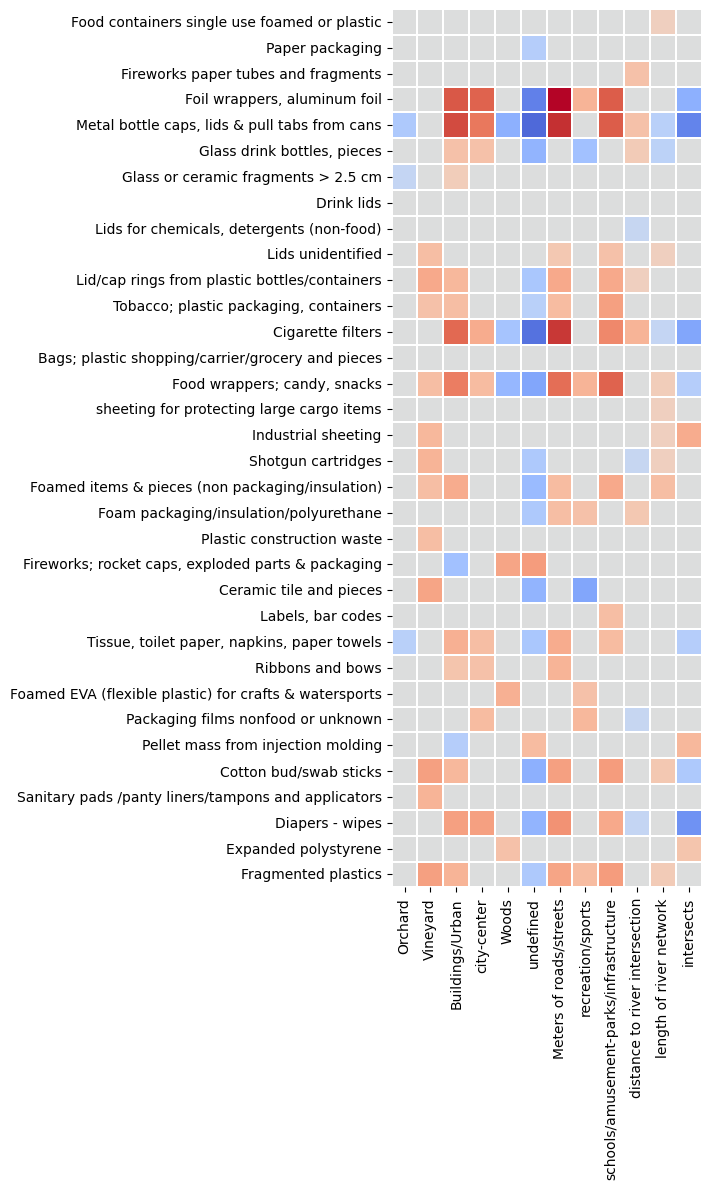

In [15]:

all_results = all_results.round(2)
fig, ax = plt.subplots(figsize=(16,12))

sns.heatmap(all_results,cmap="coolwarm", yticklabels=True, linecolor="white", linewidths=.1, ax=ax, cbar=False, center=0,square=True)
plt.tight_layout()
plt.savefig("resources/output/tlm-3d-2022-land-use.jpeg", format="jpg", dpi=300)

plt.show()

In [16]:
today = dt.datetime.now().date().strftime("%d/%m/%Y")
where = "Biel, CH"

my_block = f"""

This script updated {today} in {where}

> \u2764\ufe0f what you do everyday

_ANALYSTATHAMMERDIRT_
"""

md(my_block)



This script updated 12/04/2023 in Biel, CH

> ❤️ what you do everyday

_ANALYSTATHAMMERDIRT_


In [17]:
%watermark --iversions -b -r

Git repo: https://github.com/hammerdirt-analyst/landuse.git

Git branch: main

json      : 2.0.9
scipy     : 1.10.1
PIL       : 9.5.0
pandas    : 2.0.0
IPython   : 8.12.0
numpy     : 1.24.2
seaborn   : 0.12.2
matplotlib: 3.7.1

